In [4]:
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import d3p
from twinify.napsu_mq.napsu_mq import NapsuMQModel
from twinify.napsu_mq import rubins_rules as rubin
from twinify.napsu_mq import marginal_query
from twinify.napsu_mq.markov_network import MarkovNetwork
from twinify.napsu_mq import maximum_entropy_inference as mei
from twinify.napsu_mq import privacy_accounting
from tests.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from tqdm import tqdm

In [5]:
n = 2000
d = 4
n_syn_datasets = 100
n_syn_dataset = n

epsilon = 1.0
delta = n**(-2)

conf_levels = np.linspace(0.05, 0.95, 19)
true_params = jnp.array((0.4, 0.3, 0.0))


def gen_data(rng):
    data_gen = BinaryLogisticRegressionDataGenerator(true_params)
    data = data_gen.generate_data(n, rng)
    x_values = data_gen.x_values
    values_by_feature = data_gen.values_by_feature

    return data, x_values, values_by_feature

def get_dp_suff_stat(rng, queries, data):
    suff_stat = jnp.sum(queries.flatten()(data), axis=0)
    sensitivity = np.sqrt(suff_stat.shape[0])
    sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
    dp_suff_stat = suff_stat + sigma_DP * jax.random.normal(key=rng, shape=suff_stat.shape)
    return dp_suff_stat, sigma_DP

def record(ci, conf_level, dim, repeat_ind):
    return {
        "has_coverage": int(ci[0] <= true_params[dim].item() <= ci[1]),
        "conf_level": conf_level,
        "dim": dim,
        "repeat_ind": repeat_ind
    }


def logistic_regression(datasets, col_to_predict=None, add_constant=True):
    m, n, d = datasets.shape
    if col_to_predict is None: col_to_predict = d - 1
    feature_cols = set(range(d))
    feature_cols.remove(col_to_predict)
    feature_cols = list(feature_cols)

    num_coefs = d if add_constant else d - 1
    q = np.zeros((m, num_coefs))
    u = np.zeros((m, num_coefs))
    for i in range(m):
        dataset = datasets[i,:,:]
        feature_array = sm.add_constant(dataset[:, feature_cols], has_constant="add") if add_constant else dataset[:, feature_cols]
        y_array = dataset[:, col_to_predict]

        try:
            syn_model = sm.GLM(y_array, feature_array, family=sm.families.Binomial())
            syn_result = syn_model.fit()

            q[i, :] = syn_result.params
            u[i, :] = syn_result.bse**2
        except PerfectSeparationError:
            q[i, :] = np.full(num_coefs, np.nan)
            u[i, :] = np.full(num_coefs, np.nan)

    return q, u

In [6]:
n_repeats = 50
records = []
rng = d3p.random.PRNGKey(74249069)
rngs = d3p.random.split(rng, n_repeats)

for i in tqdm(range(n_repeats)):
    data_rng, inference_rng, sampling_rng = d3p.random.split(rngs[i], 3)
    data_rng = d3p.random.convert_to_jax_rng_key(data_rng)
    
    data, x_values, values_by_feature = gen_data(data_rng)
    data = pd.DataFrame(data, dtype="int")

    model = NapsuMQModel(column_feature_set=[tuple(range(d))], use_laplace_approximation=False)
    result = model.fit(
        data=data,
        rng=inference_rng,
        epsilon=epsilon,
        delta=delta,
        query_sets=[tuple(range(d))]
    )

    synthetic_dfs = result.generate(
        rng=sampling_rng, 
        num_data_per_parameter_sample=n_syn_dataset, 
        num_parameter_samples=n_syn_datasets,
        single_dataframe=False
    )

    syn_datasets = np.stack(synthetic_dfs, axis=0)

    q, u = logistic_regression(syn_datasets, add_constant=False)
    for j in range(d - 1):
        for conf_level in conf_levels:
            qi = q[:,j]
            ui = u[:,j]
            inds = (np.isfinite(qi) & np.isfinite(ui))
            qi = qi[inds]
            ui = ui[inds]
            ci = rubin.conf_int(qi, ui, conf_level)
            records.append(record(ci, conf_level, j, i))


df = pd.DataFrame.from_records(records)

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 22826.14it/s]


4it [00:00, 13981.01it/s]


2it [00:00, 4586.45it/s]


4it [00:00, 17260.51it/s]


8it [00:00, 5984.38it/s]


8it [00:00, 17349.76it/s]


4it [00:00, 7247.18it/s]


8it [00:00, 17697.49it/s]


8it [00:00, 9672.65it/s]


4it [00:00, 24528.09it/s]


2it [00:00, 14074.85it/s]


4it [00:00, 15563.28it/s]


16it [00:00, 9668.47it/s]


2it [00:00, 22982.49it/s]


2it [00:00, 7436.71it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 418.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 16611.10it/s]


4it [00:00, 10727.12it/s]


2it [00:00, 19972.88it/s]


4it [00:00, 20213.51it/s]


8it [00:00, 30174.85it/s]


8it [00:00, 21550.69it/s]


4it [00:00, 31011.49it/s]


8it [00:00, 16594.67it/s]


8it [00:00, 23464.64it/s]


4it [00:00, 14181.92it/s]


2it [00:00, 26296.58it/s]


4it [00:00, 25003.30it/s]


16it [00:00, 6972.35it/s]


2it [00:00, 19645.45it/s]


2it [00:00, 29330.80it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 591.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36711.63it/s]


4it [00:00, 30066.70it/s]


2it [00:00, 36472.21it/s]


4it [00:00, 37701.61it/s]


8it [00:00, 33621.68it/s]


8it [00:00, 28244.47it/s]


4it [00:00, 33893.37it/s]


8it [00:00, 32109.50it/s]


8it [00:00, 33621.68it/s]


4it [00:00, 33893.37it/s]


2it [00:00, 32640.50it/s]


4it [00:00, 25614.07it/s]


16it [00:00, 18162.07it/s]


2it [00:00, 39383.14it/s]


2it [00:00, 36954.22it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1062.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 32263.88it/s]


4it [00:00, 43351.98it/s]


2it [00:00, 27685.17it/s]


4it [00:00, 35772.32it/s]


8it [00:00, 30393.51it/s]


8it [00:00, 27594.11it/s]


4it [00:00, 40427.03it/s]


8it [00:00, 30643.32it/s]


8it [00:00, 35544.95it/s]


4it [00:00, 33026.02it/s]


2it [00:00, 39199.10it/s]


4it [00:00, 44979.13it/s]


16it [00:00, 20919.22it/s]


2it [00:00, 37117.73it/s]


2it [00:00, 39945.75it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1097.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 21732.15it/s]


4it [00:00, 22733.36it/s]


2it [00:00, 16946.68it/s]


4it [00:00, 21024.08it/s]


8it [00:00, 18345.78it/s]


8it [00:00, 30643.32it/s]


4it [00:00, 30012.91it/s]


8it [00:00, 24157.26it/s]


8it [00:00, 28876.45it/s]


4it [00:00, 23399.19it/s]


2it [00:00, 35696.20it/s]


4it [00:00, 40524.68it/s]


16it [00:00, 17508.18it/s]


2it [00:00, 7781.64it/s]


2it [00:00, 2902.63it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 691.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 24244.53it/s]


4it [00:00, 28149.69it/s]


2it [00:00, 16644.06it/s]


4it [00:00, 21399.51it/s]


8it [00:00, 31388.62it/s]


8it [00:00, 26317.20it/s]


4it [00:00, 38479.85it/s]


8it [00:00, 24618.07it/s]


8it [00:00, 30066.70it/s]


4it [00:00, 32326.04it/s]


2it [00:00, 29852.70it/s]


4it [00:00, 41221.66it/s]


16it [00:00, 12811.93it/s]


2it [00:00, 10645.44it/s]


2it [00:00, 14488.10it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 596.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3753.46it/s, 7 steps of size 2.69e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 24855.13it/s]


4it [00:00, 30283.78it/s]


2it [00:00, 23831.27it/s]


4it [00:00, 38130.04it/s]


8it [00:00, 23448.24it/s]


8it [00:00, 22339.83it/s]


4it [00:00, 38479.85it/s]


8it [00:00, 26214.40it/s]


8it [00:00, 28752.73it/s]


4it [00:00, 20311.40it/s]


2it [00:00, 32896.50it/s]


4it [00:00, 36711.63it/s]


16it [00:00, 16496.77it/s]


2it [00:00, 25040.62it/s]


2it [00:00, 36954.22it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3578.29it/s, 79 steps of size 1.59e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40041.09it/s]


4it [00:00, 29228.60it/s]


2it [00:00, 12122.27it/s]


4it [00:00, 20945.34it/s]


8it [00:00, 19130.23it/s]


8it [00:00, 19328.59it/s]


4it [00:00, 20945.34it/s]


8it [00:00, 23188.96it/s]


8it [00:00, 25477.93it/s]


4it [00:00, 38479.85it/s]


2it [00:00, 29852.70it/s]


4it [00:00, 20610.83it/s]


16it [00:00, 13695.69it/s]


2it [00:00, 33288.13it/s]


2it [00:00, 32896.50it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3978.10it/s, 7 steps of size 3.50e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31536.12it/s]


4it [00:00, 16810.84it/s]


2it [00:00, 5038.20it/s]


4it [00:00, 22982.49it/s]


8it [00:00, 17024.06it/s]


8it [00:00, 21509.25it/s]


4it [00:00, 33893.37it/s]


8it [00:00, 29641.72it/s]


8it [00:00, 26504.29it/s]


4it [00:00, 32263.88it/s]


2it [00:00, 33288.13it/s]


4it [00:00, 16946.68it/s]


16it [00:00, 16312.32it/s]


2it [00:00, 13617.87it/s]


2it [00:00, 8338.58it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3854.23it/s, 7 steps of size 2.58e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 27822.91it/s]


4it [00:00, 17242.77it/s]


2it [00:00, 24314.81it/s]


4it [00:00, 30283.78it/s]


8it [00:00, 22982.49it/s]


8it [00:00, 27869.13it/s]


4it [00:00, 42048.16it/s]


8it [00:00, 23530.46it/s]


8it [00:00, 22354.72it/s]


4it [00:00, 42908.48it/s]


2it [00:00, 30283.78it/s]


4it [00:00, 35469.80it/s]


16it [00:00, 8430.76it/s]


2it [00:00, 15363.75it/s]


2it [00:00, 15169.27it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3788.30it/s, 7 steps of size 2.49e-01. acc. prob=0.87]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 23663.21it/s]


4it [00:00, 16677.15it/s]


2it [00:00, 28244.47it/s]


4it [00:00, 8116.70it/s]


8it [00:00, 14538.32it/s]


8it [00:00, 28581.29it/s]


4it [00:00, 30615.36it/s]


8it [00:00, 26609.38it/s]


8it [00:00, 26132.74it/s]


4it [00:00, 19043.38it/s]


2it [00:00, 7869.24it/s]


4it [00:00, 28008.71it/s]


16it [00:00, 14404.13it/s]


2it [00:00, 31300.78it/s]


2it [00:00, 33825.03it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3847.23it/s, 7 steps of size 2.79e-01. acc. prob=0.84]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 18436.50it/s]


4it [00:00, 31011.49it/s]


2it [00:00, 22733.36it/s]


4it [00:00, 43018.50it/s]


8it [00:00, 34344.35it/s]


8it [00:00, 28173.33it/s]


4it [00:00, 25497.29it/s]


8it [00:00, 19362.05it/s]


8it [00:00, 20410.24it/s]


4it [00:00, 26843.55it/s]


2it [00:00, 6737.84it/s]


4it [00:00, 29026.33it/s]


16it [00:00, 16827.70it/s]


2it [00:00, 21076.90it/s]


2it [00:00, 35848.75it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3883.97it/s, 23 steps of size 2.13e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3769.57it/s, 7 steps of size 2.41e-01. acc. prob=0.89]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 20610.83it/s]


4it [00:00, 21050.46it/s]


2it [00:00, 3210.34it/s]


4it [00:00, 19901.80it/s]


8it [00:00, 22857.24it/s]


8it [00:00, 25890.77it/s]


4it [00:00, 33091.16it/s]


8it [00:00, 32768.00it/s]


8it [00:00, 24855.13it/s]


4it [00:00, 23663.21it/s]


2it [00:00, 29026.33it/s]


4it [00:00, 29433.71it/s]


16it [00:00, 17876.63it/s]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3690.16it/s, 7 steps of size 2.24e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4046.88it/s, 7 steps of size 2.64e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31011.49it/s]


4it [00:00, 17403.75it/s]


2it [00:00, 20410.24it/s]


4it [00:00, 28630.06it/s]


8it [00:00, 24244.53it/s]


8it [00:00, 19854.69it/s]


4it [00:00, 26504.29it/s]


8it [00:00, 23967.45it/s]


8it [00:00, 24087.89it/s]


4it [00:00, 40820.48it/s]


2it [00:00, 17225.07it/s]


4it [00:00, 33156.55it/s]


16it [00:00, 16085.54it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3819.87it/s, 7 steps of size 2.26e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3996.83it/s, 7 steps of size 2.40e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 32513.98it/s]


4it [00:00, 24385.49it/s]


2it [00:00, 21509.25it/s]


4it [00:00, 35098.78it/s]


8it [00:00, 21988.49it/s]


8it [00:00, 27503.63it/s]


4it [00:00, 35320.45it/s]


8it [00:00, 22236.20it/s]


8it [00:00, 25712.21it/s]


4it [00:00, 21509.25it/s]


2it [00:00, 33961.98it/s]


4it [00:00, 24855.13it/s]


16it [00:00, 10294.35it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3795.06it/s, 7 steps of size 2.59e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3717.93it/s, 7 steps of size 2.57e-01. acc. prob=0.87]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31068.92it/s]


4it [00:00, 11366.68it/s]


2it [00:00, 22192.08it/s]


4it [00:00, 11467.68it/s]


8it [00:00, 26588.30it/s]


8it [00:00, 26567.25it/s]


4it [00:00, 27548.79it/s]


8it [00:00, 23882.16it/s]


8it [00:00, 13241.69it/s]


4it [00:00, 29382.16it/s]


2it [00:00, 23301.69it/s]


4it [00:00, 37365.74it/s]


16it [00:00, 17110.88it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3967.74it/s, 7 steps of size 2.83e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4108.83it/s, 7 steps of size 3.18e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 8661.44it/s]


4it [00:00, 3850.63it/s]


2it [00:00, 20262.34it/s]


4it [00:00, 33893.37it/s]


8it [00:00, 26400.03it/s]


8it [00:00, 30897.27it/s]


4it [00:00, 22951.05it/s]


8it [00:00, 27191.60it/s]


8it [00:00, 26400.03it/s]


4it [00:00, 14388.69it/s]


2it [00:00, 28149.69it/s]


4it [00:00, 9950.90it/s]


16it [00:00, 16861.52it/s]



sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4095.05it/s, 7 steps of size 3.40e-01. acc. prob=0.87]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3974.42it/s, 15 steps of size 3.35e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 10255.02it/s]


4it [00:00, 12122.27it/s]


2it [00:00, 13086.75it/s]


4it [00:00, 14230.04it/s]


8it [00:00, 16100.98it/s]


8it [00:00, 23109.11it/s]


4it [00:00, 24244.53it/s]


8it [00:00, 26420.81it/s]


8it [00:00, 8367.69it/s]


4it [00:00, 21481.71it/s]


2it [00:00, 19239.93it/s]


4it [00:00, 17242.77it/s]


16it [00:00, 13320.54it/s]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 2842.71it/s, 7 steps of size 1.10e-01. acc. prob=0.84]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3155.27it/s, 7 steps of size 1.37e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 4957.81it/s]


4it [00:00, 14278.48it/s]


2it [00:00, 17225.07it/s]


4it [00:00, 28777.39it/s]


8it [00:00, 30093.66it/s]


8it [00:00, 23950.34it/s]


4it [00:00, 38043.57it/s]


8it [00:00, 26504.29it/s]


8it [00:00, 31625.29it/s]


4it [00:00, 31242.49it/s]


2it [00:00, 8200.01it/s]


4it [00:00, 28149.69it/s]


16it [00:00, 12363.46it/s]


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4089.96it/s, 7 steps of size 2.67e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4147.68it/s, 3 steps of size 2.94e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31714.96it/s]


4it [00:00, 42581.77it/s]


2it [00:00, 34379.54it/s]


4it [00:00, 32513.98it/s]


8it [00:00, 19011.01it/s]


8it [00:00, 29001.24it/s]


4it [00:00, 33621.68it/s]


8it [00:00, 27302.22it/s]


8it [00:00, 20841.26it/s]


4it [00:00, 41221.66it/s]


2it [00:00, 33961.98it/s]


4it [00:00, 43804.74it/s]


16it [00:00, 17471.72it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3959.54it/s, 7 steps of size 2.36e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3776.01it/s, 7 steps of size 2.91e-01. acc. prob=0.85]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 33026.02it/s]


4it [00:00, 30504.03it/s]


2it [00:00, 29746.84it/s]


4it [00:00, 22075.28it/s]


8it [00:00, 31040.18it/s]


8it [00:00, 32928.79it/s]


4it [00:00, 45100.04it/s]


8it [00:00, 20140.72it/s]


8it [00:00, 13859.74it/s]


4it [00:00, 25266.89it/s]


2it [00:00, 23497.50it/s]


4it [00:00, 30338.55it/s]


16it [00:00, 16578.28it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3931.35it/s, 7 steps of size 1.45e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3874.30it/s, 7 steps of size 1.76e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 26504.29it/s]


4it [00:00, 42153.81it/s]


2it [00:00, 35098.78it/s]


4it [00:00, 31476.95it/s]


8it [00:00, 23061.47it/s]


8it [00:00, 24984.69it/s]


4it [00:00, 31242.49it/s]


8it [00:00, 13373.63it/s]


8it [00:00, 22221.48it/s]


4it [00:00, 28876.45it/s]


2it [00:00, 22982.49it/s]


4it [00:00, 37365.74it/s]


16it [00:00, 17300.56it/s

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 346.33it/s, 7 steps of size 1.16e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3777.00it/s, 7 steps of size 1.71e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3733.16it/s, 7 steps of size 1.09e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 37365.74it/s]


4it [00:00, 33893.37it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 45100.04it/s]


8it [00:00, 18946.60it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 346.88it/s, 7 steps of size 1.27e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4093.89it/s, 7 steps of size 2.59e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4038.41it/s, 7 steps of size 2.38e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 25003.30it/s]


4it [00:00, 32832.13it/s]


2it [00:00, 20213.51it/s]


4it [00:00, 26132.74it/s]


8it [00:00, 31242.49it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 344.83it/s, 7 steps of size 2.25e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4112.13it/s, 7 steps of size 2.55e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3765.27it/s, 7 steps of size 1.47e-01. acc. prob=0.87]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 13378.96it/s]


4it [00:00, 27639.57it/s]


2it [00:00, 29330.80it/s]


4it [00:00, 37117.73it/s]


8it [00:00, 19553.86it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 345.56it/s, 7 steps of size 2.31e-01. acc. prob=0.87]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4056.78it/s, 31 steps of size 2.27e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4078.65it/s, 7 steps of size 2.37e-01. acc. prob=0.89]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38043.57it/s]


4it [00:00, 28777.39it/s]


2it [00:00, 28244.47it/s]


4it [00:00, 35098.78it/s]


8it [00:00, 32672.28it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 343.56it/s, 7 steps of size 3.52e-02. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3668.67it/s, 7 steps of size 6.44e-02. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3474.47it/s, 7 steps of size 1.07e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 33893.37it/s]


4it [00:00, 45466.71it/s]


2it [00:00, 13508.23it/s]


4it [00:00, 21845.33it/s]


8it [00:00, 31987.07it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 334.67it/s, 7 steps of size 3.54e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4210.12it/s, 7 steps of size 2.69e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4192.13it/s, 7 steps of size 2.82e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 28008.71it/s]


4it [00:00, 27369.03it/s]


2it [00:00, 26296.58it/s]


4it [00:00, 18176.83it/s]


8it [00:00, 20623.50it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 342.08it/s, 7 steps of size 2.26e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3950.61it/s, 7 steps of size 2.09e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4004.83it/s, 7 steps of size 3.15e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 20945.34it/s]


4it [00:00, 30727.50it/s]


2it [00:00, 24314.81it/s]


4it [00:00, 33621.68it/s]


8it [00:00, 25400.78it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 340.08it/s, 7 steps of size 5.14e-02. acc. prob=0.86]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3124.60it/s, 7 steps of size 5.12e-02. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3299.70it/s, 7 steps of size 9.63e-02. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36631.48it/s]


4it [00:00, 22104.37it/s]


2it [00:00, 17660.23it/s]


4it [00:00, 25003.30it/s]


8it [00:00, 17207.40it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 339.05it/s, 3 steps of size 2.81e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3911.39it/s, 7 steps of size 1.80e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3901.43it/s, 7 steps of size 2.14e-01. acc. prob=0.89]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 10155.70it/s]


4it [00:00, 19599.55it/s]


2it [00:00, 9393.74it/s]


4it [00:00, 26132.74it/s]


8it [00:00, 24018.92it/s]


8it [00:0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41527.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42305.66it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 344.01it/s, 7 steps of size 3.67e-01. acc. prob=0.83]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4028.24it/s, 7 steps of size 2.87e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:0

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 347.83it/s, 7 steps of size 2.69e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4192.24it/s, 7 steps of size 2.15e-01. acc. prob=0.89]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4027.07it/s, 15 steps of size 2.50e-01. acc. prob=0.87]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 26672.84it/s]


4it [00:00, 27191.60it/s]


2it [00:00, 28055.55it/s]


4it [00:00, 37365.74it/s]


8it [00:00, 28976.19it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 347.23it/s, 7 steps of size 3.81e-01. acc. prob=0.88]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3999.63it/s, 23 steps of size 2.96e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4137.73it/s, 7 steps of size 2.95e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 19328.59it/s]


4it [00:00, 32017.59it/s]


2it [00:00, 27060.03it/s]


4it [00:00, 31068.92it/s]


8it [00:00, 23713.38it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 340.92it/s, 7 steps of size 2.13e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3957.69it/s, 7 steps of size 2.31e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3789.15it/s, 7 steps of size 2.08e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 18375.92it/s]


4it [00:00, 15087.42it/s]


2it [00:00, 27413.75it/s]


4it [00:00, 28926.23it/s]


8it [00:00, 30531.79it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 340.05it/s, 7 steps of size 2.89e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3982.65it/s, 7 steps of size 2.09e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3995.08it/s, 7 steps of size 2.89e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40329.85it/s]


4it [00:00, 32832.13it/s]


2it [00:00, 32263.88it/s]


4it [00:00, 34807.50it/s]


8it [00:00, 17734.90it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:09<00:00, 307.42it/s, 7 steps of size 2.81e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3876.64it/s, 7 steps of size 2.46e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4086.15it/s, 7 steps of size 2.44e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 10672.53it/s]


4it [00:00, 5305.89it/s]


2it [00:00, 13148.29it/s]


4it [00:00, 14438.22it/s]


8it [00:00, 21440.53it/s]


8it [00:0

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 340.27it/s, 7 steps of size 3.34e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4146.10it/s, 7 steps of size 3.65e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4196.16it/s, 7 steps of size 3.11e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 35320.45it/s]


4it [00:00, 35696.20it/s]


2it [00:00, 35098.78it/s]


4it [00:00, 35772.32it/s]


8it [00:00, 23530.46it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 337.74it/s, 7 steps of size 1.38e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3675.01it/s, 7 steps of size 2.18e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3868.73it/s, 7 steps of size 1.57e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 32201.95it/s]


4it [00:00, 27962.03it/s]


2it [00:00, 35696.20it/s]


4it [00:00, 35394.97it/s]


8it [00:00, 12960.38it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 342.17it/s, 7 steps of size 1.37e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3958.70it/s, 7 steps of size 1.75e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3979.81it/s, 7 steps of size 1.47e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 35696.20it/s]


4it [00:00, 28976.19it/s]


2it [00:00, 31300.78it/s]


4it [00:00, 41630.81it/s]


8it [00:00, 19130.23it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 343.04it/s, 7 steps of size 2.26e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4109.19it/s, 7 steps of size 2.43e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4006.78it/s, 7 steps of size 2.16e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 34169.48it/s]


4it [00:00, 20286.84it/s]


2it [00:00, 20610.83it/s]


4it [00:00, 28149.69it/s]


8it [00:00, 23382.88it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 334.47it/s, 7 steps of size 2.45e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4067.57it/s, 7 steps of size 2.70e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4123.48it/s, 7 steps of size 3.00e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 15993.53it/s]


4it [00:00, 30229.22it/s]


2it [00:00, 25575.02it/s]


4it [00:00, 22641.32it/s]


8it [00:00, 25811.10it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 339.84it/s, 7 steps of size 1.12e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3985.51it/s, 7 steps of size 1.82e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3597.65it/s, 7 steps of size 2.16e-01. acc. prob=0.83]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 15391.94it/s]


4it [00:00, 33091.16it/s]


2it [00:00, 23563.51it/s]


4it [00:00, 16861.52it/s]


8it [00:00, 9510.89it/s]


8it [00:0

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 343.76it/s, 7 steps of size 2.85e-01. acc. prob=0.90]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4204.96it/s, 15 steps of size 2.10e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4088.66it/s, 7 steps of size 2.61e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 34735.44it/s]


4it [00:00, 34450.14it/s]


2it [00:00, 31655.12it/s]


4it [00:00, 37701.61it/s]


8it [00:00, 19854.69it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 343.46it/s, 7 steps of size 3.30e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4285.70it/s, 7 steps of size 3.20e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4120.26it/s, 7 steps of size 3.06e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38043.57it/s]


4it [00:00, 39662.45it/s]


2it [00:00, 10155.70it/s]


4it [00:00, 27191.60it/s]


8it [00:00, 19854.69it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 328.68it/s, 7 steps of size 2.57e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3913.56it/s, 7 steps of size 2.38e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3853.43it/s, 7 steps of size 2.13e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 27639.57it/s]


4it [00:00, 42153.81it/s]


2it [00:00, 34952.53it/s]


4it [00:00, 31775.03it/s]


8it [00:00, 24297.20it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 338.61it/s, 7 steps of size 1.82e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3841.01it/s, 7 steps of size 1.93e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3916.17it/s, 7 steps of size 1.39e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40427.03it/s]


4it [00:00, 36002.61it/s]


2it [00:00, 30727.50it/s]


4it [00:00, 41221.66it/s]


8it [00:00, 20725.41it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 342.01it/s, 7 steps of size 2.52e-01. acc. prob=0.86]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3945.84it/s, 7 steps of size 2.14e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3922.72it/s, 7 steps of size 2.29e-01. acc. prob=0.89]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 32326.04it/s]


4it [00:00, 26843.55it/s]


2it [00:00, 17225.07it/s]


4it [00:00, 33554.43it/s]


8it [00:00, 21974.09it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 338.34it/s, 7 steps of size 2.71e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4033.67it/s, 7 steps of size 3.54e-01. acc. prob=0.88]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4166.48it/s, 31 steps of size 2.97e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 23967.45it/s]


4it [00:00, 23140.99it/s]


2it [00:00, 8200.01it/s]


4it [00:00, 19714.71it/s]


8it [00:00, 19474.42it/s]


8it [00:0

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 343.21it/s, 7 steps of size 3.47e-01. acc. prob=0.86]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4259.42it/s, 3 steps of size 2.99e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4329.07it/s, 7 steps of size 3.15e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 14339.50it/s]


4it [00:00, 24528.09it/s]


2it [00:00, 22982.49it/s]


4it [00:00, 29433.71it/s]


8it [00:00, 16488.66it/s]


8it [00:

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:08<00:00, 335.87it/s, 15 steps of size 2.55e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4171.07it/s, 7 steps of size 2.48e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3986.15it/s, 7 steps of size 3.20e-01. acc. prob=0.89]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [15:13<00:00, 18.26s/it]


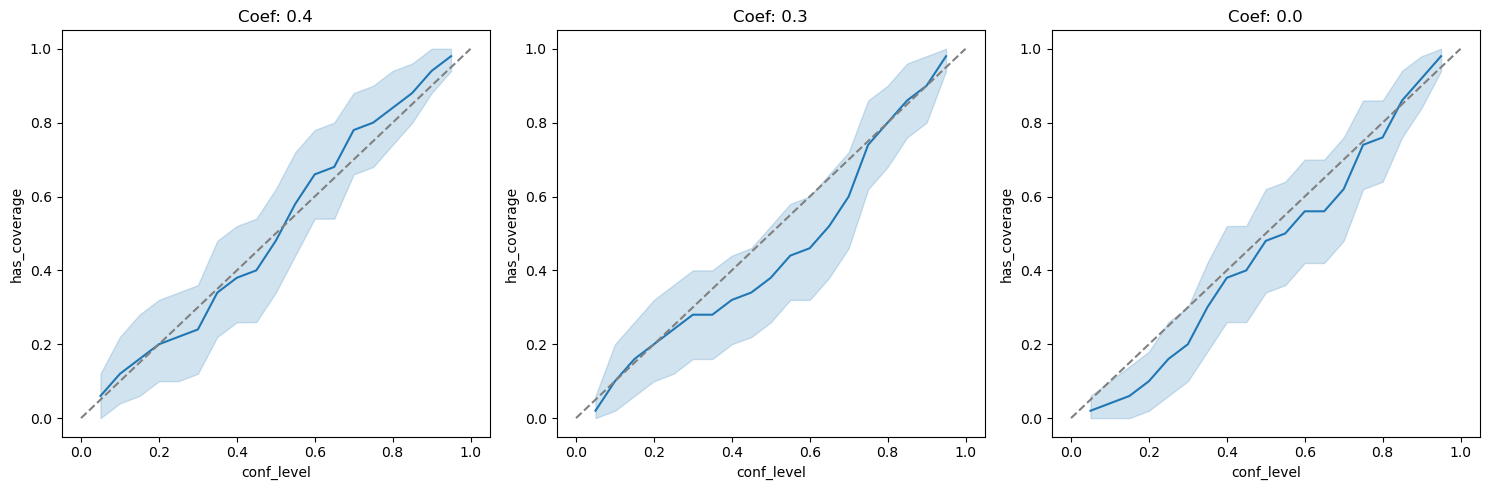

In [7]:
fig, axes = plt.subplots(1, d - 1, figsize=(5 * (d - 1), 5))
for i in range(d - 1):
    cdf = df[df.dim == i]
    ax = axes[i]
    sns.lineplot(data=cdf, x="conf_level", y="has_coverage", ax=ax)
    ax.plot((0, 1), (0, 1), linestyle="dashed", color="grey")
    ax.set_title("Coef: {}".format(true_params[i].item()))

plt.tight_layout()
plt.show()